<a href="https://colab.research.google.com/github/daisy-dotcom/ms_pacman/blob/main/Copy_of_ms_pacman_ppo_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Only run to save to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# run this cell once per Colab session
!apt update
!apt-get install xvfb x11-utils
!python -m pip install --upgrade swig
!python -m pip install --upgrade pyvirtualdisplay moviepy
!python -m pip install --upgrade gymnasium[accept-rom-license,atari,box2d,classic_control,mujoco,toy_text]
!python -m pip install torchinfo

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,032 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,451 kB]
Hit:13 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ub

In [ ]:
# import necessary libraries
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
from collections import deque
from pyvirtualdisplay import Display
import moviepy.editor as mpy
from torchinfo import summary
import random
import ale_py

gym.register_envs(ale_py)
# create and start virtual display
display = Display(backend='xvfb')
display.start()

  if event.key is 'enter':



#### Use GPU if available

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  torch.set_default_device(torch.device(device))

torch.cuda.is_available()

True

In [ ]:
torch.get_default_device()

device(type='cuda', index=0)

#### Decorator to Add Functions to Classes

In [ ]:
# Register functions as methods
# in classes
def add_to_class(Class):
  def wrapper(obj):
    setattr(Class, obj.__name__, obj)
  return wrapper

Seed to Test Correct Implementation

In [ ]:
#seed = 12345
#random.seed(seed)
#np.random.seed(seed)
#torch.manual_seed(seed)
#if torch.cuda.is_available():
#  torch.backends.cudnn.deterministic = True

#### Set Seed to None

In [ ]:
seed=None

## Class to Store Rollout
Creates a dataset with the rollout data which will be passed to a Dataloader to create the mini-batches to update the actor and critic networks.

Source: Ehsan Kamalinejad. (2023). PPO Training. https://colab.research.google.com/drive/1AmdtDNd_DUVRJlluaKIGT19BzBZ7loVZ?usp=sharing&authuser=1#scrollTo=56b3d5ca

In [ ]:
class Storage(Dataset):
    def __init__(self, rollout, advantages, returns, envs):
        # fill in the storage and flatten the parallel trajectories
        self.observations = rollout['obs'].reshape((-1,) +  envs.single_observation_space.shape)
        self.logprobs = rollout['logprobs'].reshape(-1)
        self.actions = rollout['actions'].reshape((-1,) +  envs.single_action_space.shape).long()
        self.advantages = advantages.reshape(-1)
        self.returns = returns.reshape(-1)

    def __getitem__(self, ix: int):
        item = [
            self.observations[ix],
            self.logprobs[ix],
            self.actions[ix],
            self.advantages[ix],
            self.returns[ix]
        ]
        return item

    def __len__(self) -> int:
        return len(self.observations)

## Modified Value Network (Critic) & Policy Network (Actor)
Use Tanh activation and orthogonal weight initilisation over Xavier weight initilisation to improve returns per episode.

Source: Huang, Shengyi; Dossa, Rousslan Fernand Julien; Raffin, Antonin; Kanervisto, Anssi; Wang, Weixun. (2022). The 37 Implementation Details of Proximal Policy Optimization. https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/

### Value Network

In [ ]:
class PPOVNetwork(nn.Module):
    def __init__(self,
                 in_channels,
                 hidden_sizes,
                 output_size,
                 learning_rate):
        super().__init__()

        # create network layers
        layers = nn.ModuleList()

        # input layers
        layer = self.init_weights((nn.Linear(in_channels, hidden_sizes[0])))
        layers.append(layer)

        layers.append(nn.Tanh())

        # hidden layers
        for i in range(len(hidden_sizes)-1):
            layer = self.init_weights(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            activation = nn.Tanh()
            layers.append(layer)
            layers.append(activation)

        # output layers
        layers.append(self.init_weights(nn.Linear(hidden_sizes[-1], output_size), std=1.0))

        # combine layers into feed-forward network
        self.net = nn.Sequential(*layers)

        # select loss function and optimizer
        # note: original paper uses modified MSE loss and RMSprop
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(),
                                          lr=learning_rate)

        if torch.cuda.is_available():
          self.device = torch.device('cuda:0')
        else:
          self.device = torch.device('cpu')

        self.to(self.device)

    def forward(self, x):
        # convert input to torch format
        if not torch.is_tensor(x):# or x.dtype != torch.float:
            x = torch.tensor(x, dtype=torch.float)
        x = x.to(self.device)
        # return output of Q-network
        return self.net(x)

    def update(self, value_loss):
        # update network weights for a minibatch of inputs and targets:
        self.optimizer.zero_grad()
        loss = value_loss
        loss.backward()
        self.optimizer.step()

    def copy_from(self, qnetwork):
        # copy weights from another Q-network
        self.net.load_state_dict(qnetwork.net.state_dict())

### Policy Network

In [ ]:
class PPOPolicyNetwork(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_sizes,
                 output_size,
                 learning_rate):
        super().__init__()
        # create network layers
        layers = nn.ModuleList()

        # input layers
        layer = self.init_weights((nn.Linear(input_size, hidden_sizes[0])))
        layers.append(layer)

        layers.append(nn.Tanh())

        # hidden layers
        for i in range(len(hidden_sizes)-1):
            layer = self.init_weights(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            activation = nn.Tanh()
            layers.append(layer)
            layers.append(activation)

        # output layers
        # outputs a 1D tensor of size 1 with the Q value
        layers.append(self.init_weights(nn.Linear(hidden_sizes[-1], output_size), std=1.0))

        # combine layers into feed-forward network
        self.net = nn.Sequential(*layers)

        # select loss function and optimizer
        # note: original paper uses modified MSE loss and RMSprop
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(),
                                          lr=learning_rate)

        if torch.cuda.is_available():
          self.device = torch.device('cuda:0')
        else:
          self.device = torch.device('cpu')

        self.to(self.device)

    def forward(self, x):
        # convert input to torch format
        if not torch.is_tensor(x) :#or x.dtype != torch.float:
            x = torch.tensor(x, dtype=torch.float)
        # return output of policy network
        x = x.to(self.device)
        return self.net(x)

    def update(self, policy_loss, entropy_loss):
        # update network weights for a given transition or trajectory
        self.optimizer.zero_grad()
        loss = policy_loss + entropy_loss
        loss.backward()
        self.optimizer.step()

### Orthogonal Weight Initilisation

In [ ]:
@add_to_class(PPOPolicyNetwork)
def init_weights(self, layer, std=np.sqrt(2), bias_const=0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

In [ ]:
@add_to_class(PPOVNetwork)
def init_weights(self, layer, std=np.sqrt(2), bias_const=0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

### Create a Single Environment to Add to the Vectorized Enirovnment

Source: Ehsan Kamalinejad. (2023). PPO Training. https://colab.research.google.com/drive/1AmdtDNd_DUVRJlluaKIGT19BzBZ7loVZ?usp=sharing&authuser=1#scrollTo=56b3d5ca

Source: Huang, Shengyi; Dossa, Rousslan Fernand Julien; Raffin, Antonin; Kanervisto, Anssi; Wang, Weixun. (2022). The 37 Implementation Details of Proximal Policy Optimization. https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/

In [ ]:
def make_env(name, seed=None):
    env = gym.make(name, render_mode='rgb_array_list')
    env = gym.wrappers.RecordEpisodeStatistics(env)
    if seed is not None:
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
    return env

### PPO Agent

In [ ]:
from os import stat_result
class PPOAgent():
    def __init__(self,
                 env_name='CartPole-v1',
                 n_envs=2,
                 gamma=0.99,
                 hidden_sizes=(32, 32),
                 learning_rate=0.001,
                 batch_size=32,
                 max_steps=200,
                 lam=0.95,
                 update_epochs=4,
                 clip_epsilon=0.2,
                 ent_coef=0.01,
                 max_grad_norm=0.5,
                 target_kl=None,
                 num_returns_to_avg=3,
                 num_episodes_to_avg=23,
                 total_timesteps=100000,
                 num_eval_ep=10):

        self.n_envs = n_envs
        self.env_name = env_name
        self.envs = gym.vector.SyncVectorEnv([lambda: make_env(env_name, seed) for _ in range(self.n_envs)])

        # check if the state space has correct type
        #continuous = isinstance(env.observation_space, spaces.Box) and len(env.observation_space.shape) == 1
        #assert continuous, 'Observation space must be continuous with shape (n,)'
        self.state_dims = self.envs.single_observation_space.shape[0]
        #self.state_dims = env.observation_space.n

        # check if the action space has correct type
        assert isinstance(self.envs.action_space, spaces.MultiDiscrete), 'Action space must be discrete'
        self.num_actions = self.envs.single_action_space.n

        # create actor & critic network
        self.actor = PPOPolicyNetwork(self.state_dims, hidden_sizes, self.num_actions, learning_rate)
        self.critic = PPOVNetwork(self.state_dims, hidden_sizes, 1, learning_rate)


        self.lr = learning_rate
        self.max_steps = max_steps
        self.gamma = gamma
        self.lam = lam
        self.update_epochs = update_epochs
        self.clip_epsilon = clip_epsilon
        self.ent_coef = ent_coef
        self.max_grad_norm = max_grad_norm
        self.num_returns_to_avg = num_returns_to_avg
        self.num_episodes_to_avg = num_episodes_to_avg
        self.total_timesteps = total_timesteps
        self.batch_size = batch_size
        self.num_eval_ep = num_eval_ep

    def policy(self, state, stochastic=True):
        # convert state to torch format
        if not torch.is_tensor(state):
            state = torch.tensor(state, dtype=torch.float)

        # calculate action probabilities
        logits = self.actor(state).detach()
        dist = torch.distributions.Categorical(logits=logits)
        if stochastic:
            # sample action using action probabilities
            return dist.sample().item()
        else:
            # select action with the highest probability
            # note: we ignore breaking ties randomly (low chance of happening)
            return dist.probs.argmax().item()

    def train(self):
        # train the agent for a number of updates/episodes
        self.num_steps = 0

        num_updates = self.total_timesteps//self.batch_size
        eval_after = num_updates//self.num_eval_ep

        self.all_returns = []
        self.eval_rewards = []

        for update in range(1, num_updates):
          cur_obs = torch.tensor(self.envs.reset()[0], dtype=torch.float32)
          cur_done = torch.zeros(self.n_envs)

          rollout = self.create_rollout(cur_obs, cur_done)

          cur_done = rollout['cur_done']
          cur_obs = rollout['cur_obs']
          rewards = rollout['rewards']
          dones = rollout['dones']
          values = rollout['values']

          advantage, returns = self.generalised_advantage_estimation(cur_obs, rewards, dones, values)
          dataset = Storage(rollout, advantage, returns, self.envs)

          kwargs = {'generator': torch.Generator(device=torch.get_default_device())} if torch.cuda.is_available() else {}

          train_loader = DataLoader(dataset,
                                    batch_size=self.batch_size,
                                    shuffle=True,
                                    **kwargs)

          self.ppo_update(train_loader, update, num_updates)

          if update % eval_after == 0:
            self.evaluate()

          #if len(self.all_returns) > self.num_returns_to_avg:
          print(f"\rUpdate {update}/{num_updates} Avg reward for {self.n_envs} environments: {np.mean(self.all_returns[-self.num_returns_to_avg:]):.2f}", end='')
          #print(f'Update{update}')
        self.envs.close()

    def save(self, path):
        # save network weights to a file
        torch.save(self.agent.state_dict(), path)

    def load(self, path):
        # load network weights from a file
        self.agent.load_state_dict(torch.load(path))

### Method to Get Action, Log Probabilities and Value Function Estimate
Source: Ehsan Kamalinejad. (2023). PPO Training. https://colab.research.google.com/drive/1AmdtDNd_DUVRJlluaKIGT19BzBZ7loVZ?usp=sharing&authuser=1#scrollTo=56b3d5ca

In [ ]:
@add_to_class(PPOAgent)
def get_action_and_value(self, state, action=None):
    if not torch.is_tensor(state):# or state.dtype != torch.float  :
        state = torch.tensor(state, dtype=torch.float)

    state = state.to(self.actor.device)
    #print(state)
    logits = self.actor(state).detach()
    probs = torch.distributions.Categorical(logits=logits)
    if action is None:
        action = probs.sample()

    return action, probs.log_prob(action), probs.entropy(), self.critic(state)

## Calculate the Generalised Advantage Estimation (GAE)

Calculate the n-step advantage estimate to make an estimate of TD(λ). The TD(\lambda) estimate will act as the target for the value function network to lower the variance of its estimates & the estimates of the policy network.<br>

Delta is the one step advantage estimate. <br>
$delta/td_{error}  = R_{t} + {γ}V_{t+1} - V_{t} $ <br>

$A^{GAE} (S_t, A_t ) = \sum^{∞}_{l=0}{(λγ)}^{l}δ_{t+l} $




Source: Ehsan Kamalinejad. (2023). PPO Training. https://colab.research.google.com/drive/1AmdtDNd_DUVRJlluaKIGT19BzBZ7loVZ?usp=sharing&authuser=1#scrollTo=56b3d5c

Source: Miguel Morales. (2020). Grokking Deep Reinforcement Learning. Chapter 11 Policy-gradient and Actor-Critic Methods

In [ ]:
@add_to_class(PPOAgent)
def generalised_advantage_estimation(self, cur_obs, rewards, dones, values):
  advantages = torch.zeros((self.n_envs, self.max_steps))
  last_advantage = 0

  # the value after the last step
  with torch.no_grad():
      last_value = self.critic(cur_obs).reshape(1, -1)

  # reverse recursive to calculate advantages based on the delta formula
  for t in reversed(range(self.max_steps)):
      # mask if episode completed after step t
      mask = 1.0 - dones[:, t]
      last_value = last_value * mask
      last_advantage = last_advantage * mask
      delta = rewards[:, t] + self.gamma * last_value - values[:, t]
      last_advantage = delta + self.gamma * self.lam * last_advantage
      advantages[:, t] = last_advantage
      last_value = values[:, t]

  advantages = advantages
  returns = advantages + values

  return advantages, returns

## Create Rollout
Create a new rollout everytime this method is called by stepping through the environments and collecting observations, actions, rewards, termination statuses and values after discarding the previous rollout.

Source: Ehsan Kamalinejad. (2023). PPO Training. https://colab.research.google.com/drive/1AmdtDNd_DUVRJlluaKIGT19BzBZ7loVZ?usp=sharing&authuser=1#scrollTo=56b3d5ca

In [ ]:
@add_to_class(PPOAgent)
# starting obs, current termination status, track all returns
def create_rollout(self, cur_observation, cur_done):
  """
  create trajectories from all environments and store them
  """
  # empty tensors to store the rollouts
  observations = torch.zeros((self.n_envs, self.max_steps ) + self.envs.single_observation_space.shape, dtype=torch.float)
  actions = torch.zeros((self.n_envs, self.max_steps) + self.envs.single_action_space.shape, dtype=torch.float)
  logprobs = torch.zeros((self.n_envs, self.max_steps),dtype=torch.float )
  rewards = torch.zeros((self.n_envs,self.max_steps), dtype=torch.float)
  dones = torch.zeros((self.n_envs, self.max_steps), dtype=torch.float)
  values = torch.zeros((self.n_envs, self.max_steps), dtype=torch.float)

  for t in range(self.max_steps):
      observations[:,t] = cur_observation
      dones[:,t] = cur_done
      # give observation to the model and collect action, logprobs of actions, entropy and value
      with torch.no_grad():
          action, logprob, entropy, value = self.get_action_and_value(cur_observation)

      values[:,t] = value.flatten()
      actions[:,t] = action
      logprobs[:,t] = logprob

      # apply the action to the env and collect observation and reward
      cur_observation, reward, cur_done, _, info = self.envs.step(action.cpu().numpy())
      is_done = cur_done
      rewards[:,t] = torch.tensor(reward).view(-1)
      cur_observation = torch.tensor(cur_observation, dtype=torch.float32)
      cur_done = torch.tensor(cur_done)

      if is_done.any() or t == self.max_steps-1:
        self.all_returns.append(rewards.sum(dim=1).max().cpu().numpy())
        break



  # create the rollout storage
  rollout = {
      'cur_obs': cur_observation,
      'cur_done': cur_done,
      'obs': observations,
      'actions': actions,
      'logprobs': logprobs,
      'values': values,
      'dones': dones,
      'rewards': rewards
  }

  return rollout

## Clipping the Policy Objective

Limits the changes to the policy with each optimisation step to reduce variance of the policy when a change in the environment occurs. <br>

Source: Ehsan Kamalinejad. (2023). PPO Training. https://colab.research.google.com/drive/1AmdtDNd_DUVRJlluaKIGT19BzBZ7loVZ?usp=sharing&authuser=1#scrollTo=56b3d5ca <br>

Source: Miguel Morales. (2020). Grokking Deep Reinforcement Learning. Chapter 11 Policy-gradient and Actor-Critic Methods

Source: Huang, Shengyi; Dossa, Rousslan Fernand Julien; Raffin, Antonin; Kanervisto, Anssi; Wang, Weixun. (2022). The 37 Implementation Details of Proximal Policy Optimization. https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/

In [ ]:
@add_to_class(PPOAgent)
def loss_clip(self, mb_oldlogporb, mb_newlogprob, mb_advantages):

  # ratio between new and old policy
  ratio = torch.exp(mb_newlogprob - mb_oldlogporb)
  policy_loss = -mb_advantages * ratio

  # clipped policy gradient loss enforces closeness
  clipped_loss = -mb_advantages * torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon)
  pessimistic_loss = torch.max(policy_loss, clipped_loss).mean()
  return pessimistic_loss


## Calculating the Loss of the Value Function

Use the previously calculates GAE as a TD(λ) estimate to train the critic networks.<br>
$mb\_oldreturns (TD(λ)) = advantages + values $

Source: Ehsan Kamalinejad. (2023). PPO Training. https://colab.research.google.com/drive/1AmdtDNd_DUVRJlluaKIGT19BzBZ7loVZ?usp=sharing&authuser=1#scrollTo=56b3d5ca

In [ ]:
@add_to_class(PPOAgent)
def loss_vf(self, mb_oldreturns, mb_newvalues):
    mb_newvalues = mb_newvalues.view(-1)
    loss = 0.5 * ((mb_newvalues - mb_oldreturns) ** 2).mean()
    return loss

## Mini-batch Updates
Break the rollout collected into mini-batches of the same size to compute the gradients and losses and finally global gradient clipping on both the policy and value gradients.

Source: Source: Ehsan Kamalinejad. (2023). PPO Training. https://colab.research.google.com/drive/1AmdtDNd_DUVRJlluaKIGT19BzBZ7loVZ?usp=sharing&authuser=1#scrollTo=56b3d5ca

Source: Source: Huang, Shengyi; Dossa, Rousslan Fernand Julien; Raffin, Antonin; Kanervisto, Anssi; Wang, Weixun. (2022). The 37 Implementation Details of Proximal Policy Optimization. https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/

In [ ]:
@add_to_class(PPOAgent)
def ppo_update(self, trainloader, update, num_updates):

  # linearly shrink the learning rate from the initial lr to zero
  # for both the actor and critic networks
  frac = 1.0 - (update - 1.0) / num_updates
  self.actor.optimizer.param_groups[0]["lr"] = frac * self.lr
  self.critic.optimizer.param_groups[0]["lr"] = frac * self.lr

  # update loop
  for epoch in range(self.update_epochs):
      for batch in trainloader:
          mb_observations, mb_logprobs, mb_actions, mb_advantages, mb_returns = batch

          # calculate the distribution of actions through the updated model revisiting the old trajectories
          _, mb_newlogprob, mb_entropy, mb_newvalues = self.get_action_and_value(mb_observations, mb_actions)

          policy_loss = self.loss_clip(mb_logprobs, mb_newlogprob, mb_advantages)

          value_loss = self.loss_vf(mb_returns, mb_newvalues)
          self.critic.update(value_loss)

          # average entory of the action space
          entropy_loss = mb_entropy.mean()

          self.actor.update(policy_loss.clone().detach().requires_grad_(True), entropy_loss.clone().detach().requires_grad_(True))

          # extra clipping of the gradients to avoid overshoots
          nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
          nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)


## Evaluate the Agent

In [ ]:
@add_to_class(PPOAgent)
def evaluate(self):
  test_env = make_env(env_name, seed)
  terminated = False
  truncated = False
  steps = 0
  total_reward = 0
  observation, _ = test_env.reset()
  observation = torch.unsqueeze(torch.tensor(observation, dtype=torch.float32),dim=0)

  while not (terminated or truncated):
      # take action based on policy
      with torch.no_grad():
        action, _, _, _ = self.get_action_and_value(observation)
      action = action.cpu().item()

      # environment receives the action and returns:
      # next observation, reward, terminated, truncated, and additional information (if applicable)
      observation, reward, terminated, truncated, info = test_env.step(action)
      observation = torch.unsqueeze(torch.tensor(observation, dtype=torch.float32),dim=0)
      total_reward += reward
      steps += 1
      #print(f'Reward: {total_reward}')

      # close the environment
      test_env.close()

  # save the total rewards of the evaluation episode
  self.eval_rewards.append(total_reward)


### Test Implementation on CartPole Env

In [ ]:
env_name = 'CartPole-v1'
n_envs = 32
gamma = 0.99
hidden_sizes = (64, 64, 64)
learning_rate = 0.001
batch_size = 32
max_steps = 64
lam = 0.95
update_epochs = 2
clip_epsilon = 0.2
ent_coef = 0.01
max_grad_norm = 0.5
num_returns_to_avg = 3
num_episodes_to_avg = 23
total_timesteps = 3000
num_eval_ep = 10

agent = PPOAgent(
    env_name = env_name,
    n_envs = n_envs,
    gamma = gamma,
    hidden_sizes = hidden_sizes,
    learning_rate = learning_rate,
    batch_size = batch_size,
    max_steps = max_steps,
    lam = lam,
    update_epochs = update_epochs,
    clip_epsilon = clip_epsilon,
    ent_coef = ent_coef,
    max_grad_norm = max_grad_norm,
    num_returns_to_avg = num_returns_to_avg,
    num_episodes_to_avg = num_episodes_to_avg,
    total_timesteps = total_timesteps,
    num_eval_ep = num_eval_ep
)


In [ ]:
agent.train()

Update 92/93 Avg reward for 32 environments: 9.67

## Plot Rewards

mean reward: 9.5
std reward: 0.9835605
max reward: 12.0
converge mean reward: 8.0


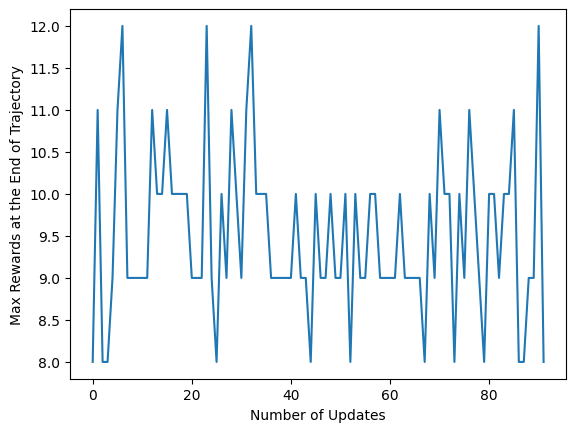

In [ ]:
if not len(agent.all_returns)%agent.num_episodes_to_avg==0:
    all_returns_truncated = np.array(agent.all_returns[:-(len(agent.all_returns)%agent.num_episodes_to_avg)])
else:
    all_returns_truncated = np.array(agent.all_returns)
#all_returns_smoothed = np.average(all_returns_truncated.reshape(-1, agent.num_episodes_to_avg), axis=1)
print('mean reward:', np.mean(all_returns_truncated))
print('std reward:', np.std(all_returns_truncated))
print('max reward:', np.max(all_returns_truncated))
print('converge mean reward:', np.mean(all_returns_truncated[-1]))
plt.xlabel('Number of Updates')
plt.ylabel('Max Rewards at the End of Trajectory')
plt.plot(all_returns_truncated)
plt.show()

Evaluation Episodes

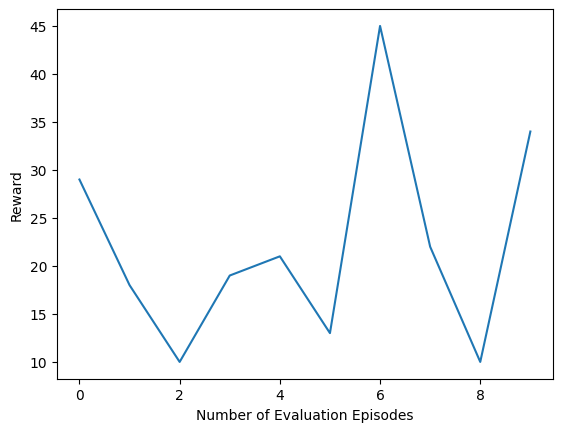

In [ ]:
plt.xlabel('Number of Evaluation Episodes')
plt.ylabel('Reward')
plt.plot(agent.eval_rewards)
plt.show()

In [ ]:
test_env = make_env(env_name, seed)
terminated = False
truncated = False
steps = 0
total_reward = 0
observation, _ = test_env.reset()
observation = torch.unsqueeze(torch.tensor(observation, dtype=torch.float32), dim=0)

while not (terminated or truncated):
    # take action based on policy
    with torch.no_grad():
      action, _, _, _ = agent.get_action_and_value(observation)
    action = action.cpu().item()

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    observation, reward, terminated, truncated, info = test_env.step(action)
    observation = torch.unsqueeze(torch.tensor(observation, dtype=torch.float32), dim=0)
    #print(f'Reward: {reward}')
    total_reward += reward
    steps += 1

print(f'Reward: {total_reward}')

# store RGB frames for the entire episode
frames = test_env.render()

# close the environment
test_env.close()

# create and play video clip using the frames and given fps
clip = mpy.ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

Reward: 26.0


### Ms Pacman Results

### Initial hyperparameters set using Schulman et al. (2017) Proximal Policy Optimisation Algorithms paper's parameter for Atari environments

* Horizon - 128
* Number of environments - 8
* Learning Rate - $2.5 × 10 ^{-4}$
* Batch size - 32
* Discount - 0.99
* GAE parameter (lambda) - 0.95
* Clipping parameter - 0.1
* Entropy coef - 0.01

In [ ]:
env_name = 'ALE/MsPacman-ram-v5'
n_envs = 8
gamma = 0.99
hidden_sizes = (64, 64, 64)
learning_rate = 0.00025
batch_size = 32
max_steps = 128
lam = 0.95
update_epochs = 2
clip_epsilon = 0.1
ent_coef = 0.01
max_grad_norm = 0.5
num_returns_to_avg = 3
num_episodes_to_avg = 5
total_timesteps = 100000
num_eval_ep = 20

agent = PPOAgent(
    env_name = env_name,
    n_envs = n_envs,
    gamma = gamma,
    hidden_sizes = hidden_sizes,
    learning_rate = learning_rate,
    batch_size = batch_size,
    max_steps = max_steps,
    lam = lam,
    update_epochs = update_epochs,
    clip_epsilon = clip_epsilon,
    ent_coef = ent_coef,
    max_grad_norm = max_grad_norm,
    num_returns_to_avg = num_returns_to_avg,
    num_episodes_to_avg = num_episodes_to_avg,
    total_timesteps = total_timesteps,
    num_eval_ep = num_eval_ep
)


In [ ]:
agent.train()

Update 3124/3125 Avg reward for 8 environments: 133.33

mean reward: 119.916664
std reward: 18.006216
max reward: 210.0
converge mean reward: 130.0


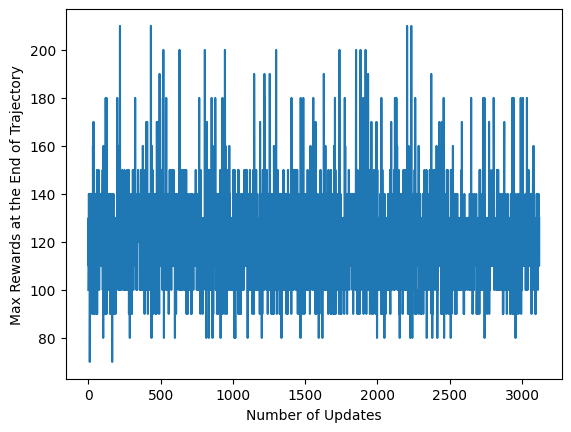

In [ ]:
if not len(agent.all_returns)%agent.num_episodes_to_avg==0:
    all_returns_truncated = np.array(agent.all_returns[:-(len(agent.all_returns)%agent.num_episodes_to_avg)])
else:
    all_returns_truncated = np.array(agent.all_returns)
#all_returns_smoothed = np.average(all_returns_truncated.reshape(-1, agent.num_episodes_to_avg), axis=1)
print('mean reward:', np.mean(all_returns_truncated))
print('std reward:', np.std(all_returns_truncated))
print('max reward:', np.max(all_returns_truncated))
print('converge mean reward:', np.mean(all_returns_truncated[-1]))
plt.xlabel('Number of Updates')
plt.ylabel('Max Rewards at the End of Trajectory')
plt.plot(all_returns_truncated)
plt.show()

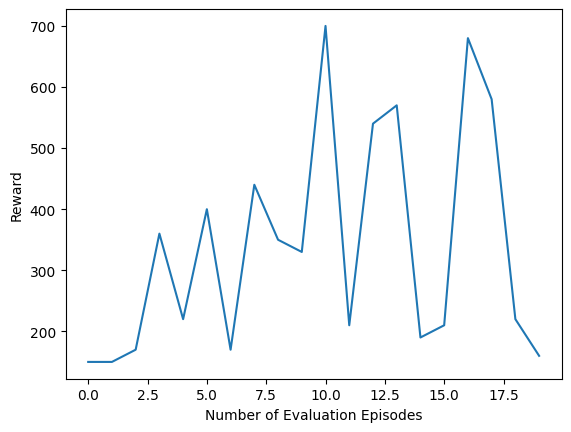

In [ ]:
plt.xlabel('Number of Evaluation Episodes')
plt.ylabel('Reward')
plt.plot(agent.eval_rewards)
plt.show()

In [ ]:
test_env = make_env(env_name, seed)
terminated = False
truncated = False
steps = 0
total_reward = 0
observation, _ = test_env.reset()
observation = torch.unsqueeze(torch.tensor(observation, dtype=torch.float32), dim=0)

while not (terminated or truncated):
    # take action based on policy
    with torch.no_grad():
      action, _, _, _ = agent.get_action_and_value(observation)
    action = action.cpu().item()

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    observation, reward, terminated, truncated, info = test_env.step(action)
    observation = torch.unsqueeze(torch.tensor(observation, dtype=torch.float32), dim=0)
    #print(f'Reward: {reward}')
    total_reward += reward
    steps += 1

print(f'Reward: {total_reward}')

# store RGB frames for the entire episode
frames = test_env.render()

# close the environment
test_env.close()

# create and play video clip using the frames and given fps
clip = mpy.ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

Reward: 300.0


### Increasing Trajectory Length
128 to 256

In [ ]:
env_name = 'ALE/MsPacman-ram-v5'
n_envs = 8
gamma = 0.99
hidden_sizes = (64, 64, 64)
learning_rate = 0.00025
batch_size = 32
max_steps = 256
lam = 0.95
update_epochs = 2
clip_epsilon = 0.1
ent_coef = 0.01
max_grad_norm = 0.5
num_returns_to_avg = 3
num_episodes_to_avg = 5
total_timesteps = 100000

agent = PPOAgent(
    env_name = env_name,
    n_envs = n_envs,
    gamma = gamma,
    hidden_sizes = hidden_sizes,
    learning_rate = learning_rate,
    batch_size = batch_size,
    max_steps = max_steps,
    lam = lam,
    update_epochs = update_epochs,
    clip_epsilon = clip_epsilon,
    ent_coef = ent_coef,
    max_grad_norm = max_grad_norm,
    num_returns_to_avg = num_returns_to_avg,
    num_episodes_to_avg = num_episodes_to_avg,
    total_timesteps = total_timesteps
)


In [ ]:
agent.train()

Update 3124/3125 Avg reward for 8 environments: 180.00

mean reward: 200.02884
std reward: 69.00877
max reward: 1730.0
converge mean reward: 220.0


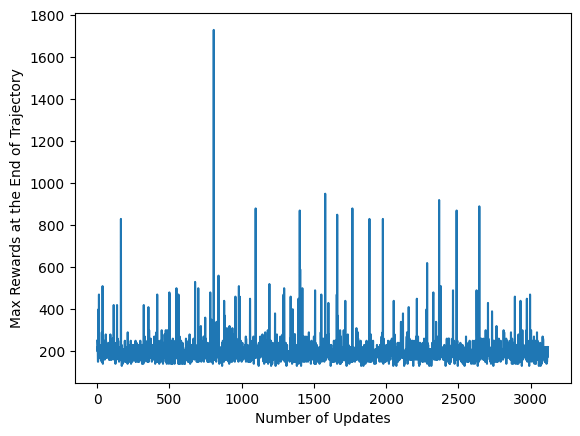

In [ ]:
if not len(agent.all_returns)%agent.num_episodes_to_avg==0:
    all_returns_truncated = np.array(agent.all_returns[:-(len(agent.all_returns)%agent.num_episodes_to_avg)])
else:
    all_returns_truncated = np.array(agent.all_returns)
#all_returns_smoothed = np.average(all_returns_truncated.reshape(-1, agent.num_episodes_to_avg), axis=1)
print('mean reward:', np.mean(all_returns_truncated))
print('std reward:', np.std(all_returns_truncated))
print('max reward:', np.max(all_returns_truncated))
print('converge mean reward:', np.mean(all_returns_truncated[-1]))
plt.xlabel('Number of Updates')
plt.ylabel('Max Rewards at the End of Trajectory')
plt.plot(all_returns_truncated)
plt.show()

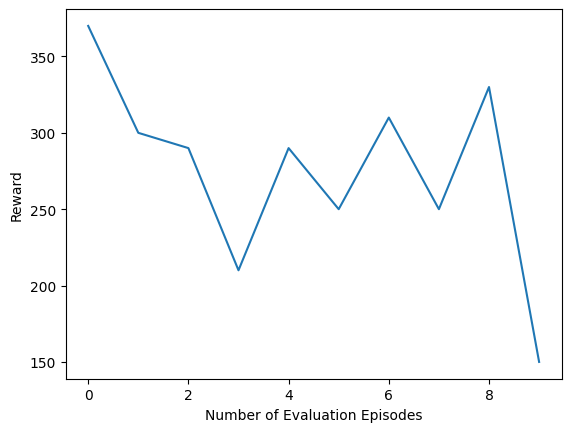

In [ ]:
plt.xlabel('Number of Evaluation Episodes')
plt.ylabel('Reward')
plt.plot(agent.eval_rewards)
plt.show()

In [ ]:
test_env = make_env(env_name, seed)
terminated = False
truncated = False
steps = 0
total_reward = 0
observation, _ = test_env.reset()
observation = torch.unsqueeze(torch.tensor(observation, dtype=torch.float32), dim=0)

while not (terminated or truncated):
    # take action based on policy
    with torch.no_grad():
      action, _, _, _ = agent.get_action_and_value(observation)
    action = action.cpu().item()

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    observation, reward, terminated, truncated, info = test_env.step(action)
    observation = torch.unsqueeze(torch.tensor(observation, dtype=torch.float32), dim=0)
    #print(f'Reward: {reward}')
    total_reward += reward
    steps += 1

print(f'Reward: {total_reward}')

# store RGB frames for the entire episode
frames = test_env.render()

# close the environment
test_env.close()

# create and play video clip using the frames and given fps
clip = mpy.ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

Reward: 190.0


#### Increasing the Number of Environments
8 to 16

In [ ]:
env_name = 'ALE/MsPacman-ram-v5'
n_envs = 16
gamma = 0.99
hidden_sizes = (64, 64, 64)
learning_rate = 0.00025
batch_size = 32
max_steps = 256
lam = 0.95
update_epochs = 2
clip_epsilon = 0.1
ent_coef = 0.01
max_grad_norm = 0.5
num_returns_to_avg = 3
num_episodes_to_avg = 5
total_timesteps = 100000

agent = PPOAgent(
    env_name = env_name,
    n_envs = n_envs,
    gamma = gamma,
    hidden_sizes = hidden_sizes,
    learning_rate = learning_rate,
    batch_size = batch_size,
    max_steps = max_steps,
    lam = lam,
    update_epochs = update_epochs,
    clip_epsilon = clip_epsilon,
    ent_coef = ent_coef,
    max_grad_norm = max_grad_norm,
    num_returns_to_avg = num_returns_to_avg,
    num_episodes_to_avg = num_episodes_to_avg,
    total_timesteps = total_timesteps
)


In [ ]:
agent.train()

Update 3124/3125 Avg reward for 16 environments: 353.33

mean reward: 352.7404
std reward: 152.56068
max reward: 1650.0
converge mean reward: 180.0


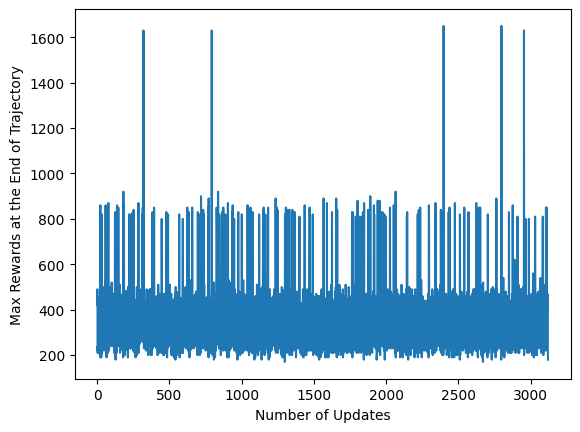

In [ ]:
if not len(agent.all_returns)%agent.num_episodes_to_avg==0:
    all_returns_truncated = np.array(agent.all_returns[:-(len(agent.all_returns)%agent.num_episodes_to_avg)])
else:
    all_returns_truncated = np.array(agent.all_returns)
#all_returns_smoothed = np.average(all_returns_truncated.reshape(-1, agent.num_episodes_to_avg), axis=1)
print('mean reward:', np.mean(all_returns_truncated))
print('std reward:', np.std(all_returns_truncated))
print('max reward:', np.max(all_returns_truncated))
print('converge mean reward:', np.mean(all_returns_truncated[-1]))
plt.xlabel('Number of Updates')
plt.ylabel('Max Rewards at the End of Trajectory')
plt.plot(all_returns_truncated)
plt.show()

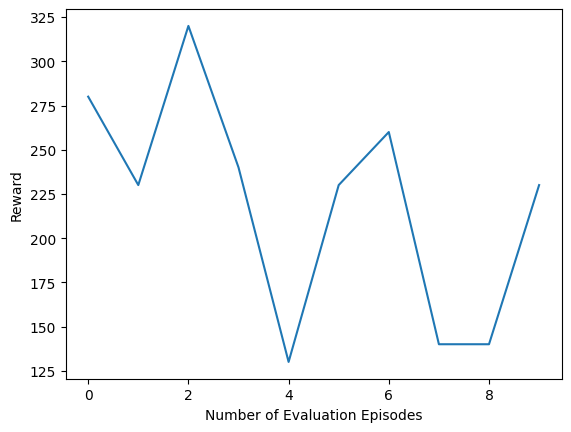

In [ ]:
plt.xlabel('Number of Evaluation Episodes')
plt.ylabel('Reward')
plt.plot(agent.eval_rewards)
plt.show()

In [ ]:
test_env = make_env(env_name, seed)
terminated = False
truncated = False
steps = 0
total_reward = 0
observation, _ = test_env.reset()
observation = torch.unsqueeze(torch.tensor(observation, dtype=torch.float32), dim=0)

while not (terminated or truncated):
    # take action based on policy
    with torch.no_grad():
      action, _, _, _ = agent.get_action_and_value(observation)
    action = action.cpu().item()

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    observation, reward, terminated, truncated, info = test_env.step(action)
    observation = torch.unsqueeze(torch.tensor(observation, dtype=torch.float32), dim=0)
    #print(f'Reward: {reward}')
    total_reward += reward
    steps += 1

print(f'Reward: {total_reward}')

# store RGB frames for the entire episode
frames = test_env.render()

# close the environment
test_env.close()

# create and play video clip using the frames and given fps
clip = mpy.ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

Reward: 400.0
